In [53]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [54]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [55]:
measurements_used = 25
time_series_used = 10
# energy_per_time = 1000
generate_graphs = False
show_plots = True

get_timeseries = False
get_measurements = True

In [56]:
# exp_name = "compiler"
# exp_name = "measuring_instrument"
exp_name = "app"
# exp_name = "run-many-times"
# exp_name = "cores"

In [57]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

idle_case_config = -1

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

# used_os_names = [
#     windows, 
#     linux
# ]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [58]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_os_names = [
        windows, 
        linux
    ]
    
    used_mi_names = [
        # ipg, scaphandre, lhm, plug, rapl, clamp, rapl
        clamp
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        # lhm#, plug
        # lhm #clamp
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]
    
if exp_name == "run-many-times":
    experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    
    used_os_names = [
        windows, 
    ]
    
    used_dut_name = [
        'workstationtwo',
    ]
    
    used_test_case_names = [
        'mandelbrot.exe',
    ]
    
    used_mi_names = [
        clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]

if exp_name == 'cores':
    experiment_name = "same-one-api-compiler-different-cores"
    experiment_number = 3
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg #, clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    used_test_case_names = [
        'nbody.exe',
        'spectral-norm.exe',
        # 'idle-case.exe'
    ]
    
    used_thread = [
        'single-threaded'
    ]
    
    used_allocated_cores = [
        ['0'], 
        ['1'], 
        ['2'],
        ['3'],
        ['4'],
        ['5'],
        ['6'],
        ['7'],
        ['8'],
        ['9'],
    ]
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = ["", "180000000", "18000"]

if exp_name == 'app':
    experiment_name = "same-mi-different-application-post-config-update"
    experiment_number = 3
    used_burn_in = 0
    
    used_test_case_name = 'idle.exe'
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg, clamp
    ]
    
    used_compilers = [
        'unkown'
    ]
    
    used_test_case_names = [
        '3d-mark.exe',
        # 'idle.exe'
    ]
    
    used_thread = [
        'multi-threaded'
    ]
    
    used_allocated_cores = [
        ['4'],
        ['4', '3'],
        ['4', '3', '2'],
        ['4', '3', '2', '1'],
        ['4', '3', '2', '1', '5'],
        ['4', '3', '2', '1', '5', '0'],
        ['4', '3', '2', '1', '5', '0', '8'],
        ['4', '3', '2', '1', '5', '0', '8', '7'],
        ['4', '3', '2', '1', '5', '0', '8', '7', '6'],
        ['4', '3', '2', '1', '5', '0', '8', '7', '6', '9'],
    ]
    
    idle_case_config = 2
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = [""]


used_mi_names.sort()
used_compilers.sort()

In [59]:
used_test_case_names

['3d-mark.exe']

### DUTs

In [60]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [61]:
dut = rep.get_devices_under_test(db)
dut.shape

(9, 4)

In [62]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut.shape

(1, 4)

### Test Cases

In [63]:
tc = rep.get_test_cases(db)

tc.shape

(32, 8)

In [64]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [65]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [66]:
used_test_case_parameters

''

### Measuring Instruments

In [67]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [68]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [69]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [70]:
config = rep.get_configurations(db)

config.shape

(32, 5)

In [71]:
config.shape

(32, 5)

In [72]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            # f"{ALLOCATED_CORES} in ('[1]')")
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
                            # f"CAST({ALLOCATED_CORES} as CHAR) = [{used_allocated_cores_str}]")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
15,16,0,200,0,"[4, 3, 2, 1, 5, 0, 8]"
16,17,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7]"
17,18,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6]"
18,19,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]"
19,20,0,200,0,[4]
20,21,0,200,0,"[4, 3]"
21,22,0,200,0,"[4, 3, 2]"
22,23,0,200,0,"[4, 3, 2, 1]"
23,24,0,200,0,"[4, 3, 2, 1, 5]"
24,25,0,200,0,"[4, 3, 2, 1, 5, 0]"


### Experiment Names

In [73]:
exp = rep.get_distinct_experiments(db)

exp.shape

(11, 2)

## Used Things

In [74]:
used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod


In [75]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [76]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
14,19,clamp,100


In [77]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
31,35,idle.exe,unkown,unknown,,application,,multi-threaded


In [78]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
15,16,0,200,0,"[4, 3, 2, 1, 5, 0, 8]"
16,17,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7]"
17,18,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6]"
18,19,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]"
19,20,0,200,0,[4]
20,21,0,200,0,"[4, 3]"
21,22,0,200,0,"[4, 3, 2]"
22,23,0,200,0,"[4, 3, 2, 1]"
23,24,0,200,0,"[4, 3, 2, 1, 5]"
24,25,0,200,0,"[4, 3, 2, 1, 5, 0]"


In [79]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

In [80]:
# [x for x in time_series[0]["fannkuch-redux.exe.rapl.workstationone.all.intel-one-api.unix"].iterrows()]

In [81]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            table.plot(x="ElapsedTime", y="ProcessorPowerInWatt")
        if "rapl" in key:
            table['rapl_column'] = df_util.get_rapl_column(table, "total_core")
            table.plot(x="ElapsedTime", y="rapl_column")
        plot.show()

In [82]:
used_configs.shape, used_dut.shape, used_mi.shape, used_tc.shape, used_idle_case.shape


((10, 5), (1, 4), (2, 3), (1, 8), (1, 8))

In [83]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
31,35,idle.exe,unkown,unknown,,application,,multi-threaded


In [84]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [85]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [86]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_watt_consumption = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption,
        idle_case_config = idle_case_config
    )

(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0].unkown.ipg.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.clamp.100.34
(1, 8)
Y - 3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.clamp.100.34
(1, 8)

In [87]:
if get_measurements:
    df_util.trim_dataframes(
        measurements_used,
        dram_energy_results,
        cpu_energy_results,
        gpu_energy_results,
        duration_results,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        temperature_end,
        temperature_begin,
        cpu_dynamic_energy_watt_consumption
    )

In [88]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [89]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_energy_results = convert_to_series(dram_energy_results)
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_energy_results = convert_to_series(cpu_energy_results)
    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_energy_results = convert_to_series(gpu_energy_results)
    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_results = convert_to_series(duration_results)
    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_energy_consumption = convert_to_series(dram_dynamic_energy_consumption)
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_energy_consumption = convert_to_series(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))
    
    cpu_dynamic_energy_watt_consumption = convert_to_series(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = pd.DataFrame(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = cpu_dynamic_watt_df.reindex(columns=sorted(cpu_dynamic_watt_df.columns))

    gpu_dynamic_energy_consumption = convert_to_series(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_consumption_results = convert_to_series(idle_cpu_consumption_results)
    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin = convert_to_series(temperature_begin)
    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end = convert_to_series(temperature_end)
    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))




In [90]:
if get_measurements:
    for column in duration_df.columns:
        duration_df[column] = duration_df[column] / 1000

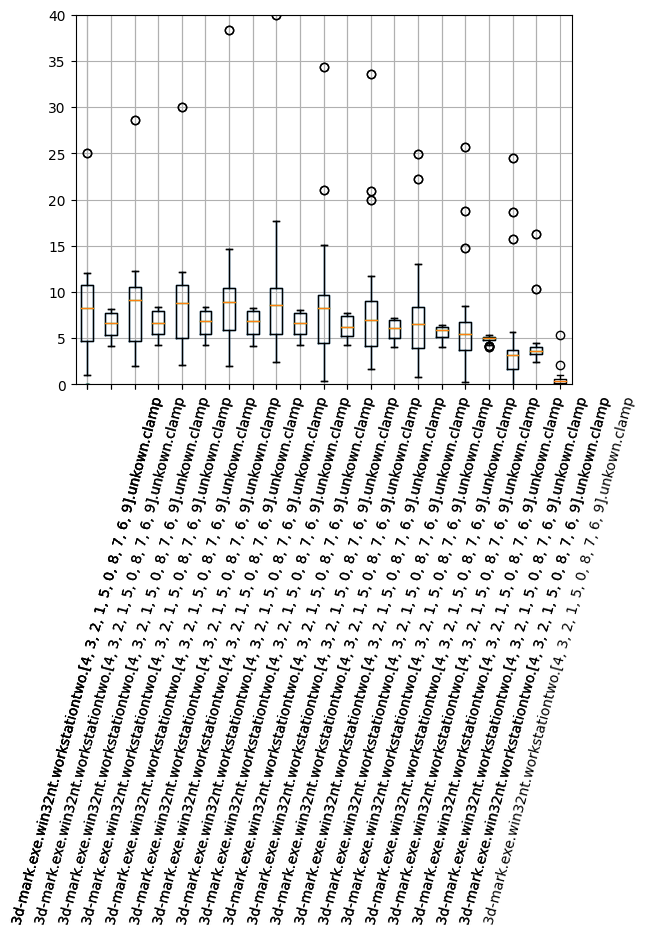

Combined CPU Energy Consumption in Joules


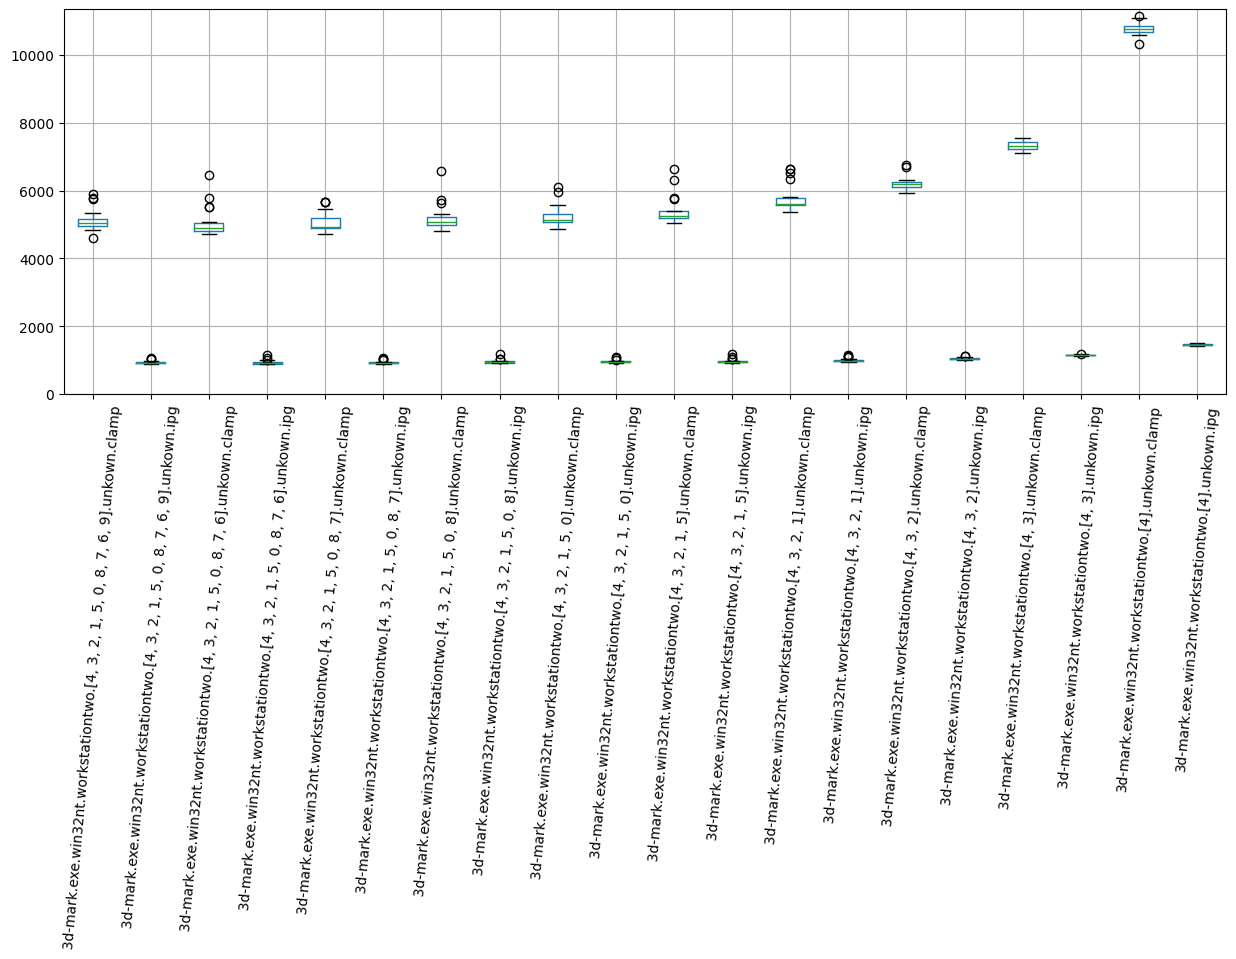

Duration of Test Case


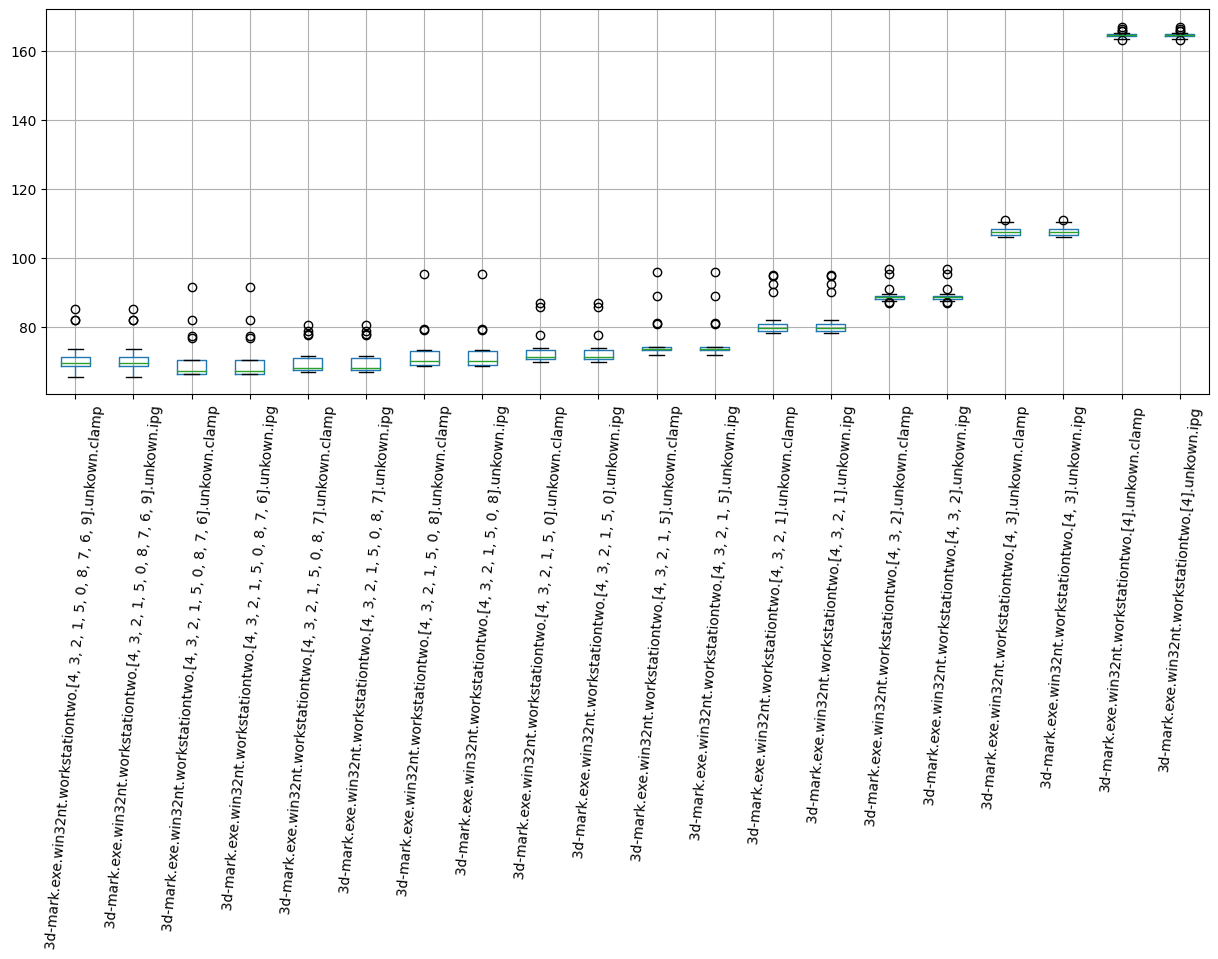

In [91]:
if get_measurements and show_plots:
    test_boxplot = dram_df.boxplot(figsize=(15,1), rot=75, column=[dram_df.columns[0]])
    test_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()
    
    
    # print("Combined DRAM Energy Consumption in Joules")
    # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=85)
    # # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=['fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt'])
    # dram_boxplot.plot()
    # plot.ylim(0, 40)
    # plot.show()

    print("Combined CPU Energy Consumption in Joules")
    cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=85)
    cpu_boxplot.plot()
    cpu_boxplot
    plot.ylim(0,max(list(cpu_df.max())) + 200)
    plot.show()

    # print("Combined GPU Energy Consumption in Joules")
    # gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=85)
    # gpu_boxplot.plot()
    # plot.ylim(0,50)
    # plot.show()

    print("Duration of Test Case")
    duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=85)
    duration_boxplot.plot()
    # plot.ylim(60,80)
    plot.show()

In [92]:
cpu_dynamic_watt_df

,"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3].unkown.ipg",3d-mark.exe.win32nt.workstationtwo.[4].unkown.clamp,3d-mark.exe.win32nt.workstationtwo.[4].unkown.ipg
0,8.364132,7.999573,9.416504,7.894226,8.978902,7.978788,7.555150,7.806952,8.188316,7.707101,8.309127,7.418009,6.440534,6.720360,6.379638,6.128806,3.760346,4.955636,0.833988,3.295764
1,8.277392,7.790980,9.525601,7.765131,8.873367,7.916648,10.140447,7.949579,8.595915,7.868141,8.735647,7.441775,6.947626,6.972392,6.436771,6.200905,4.545726,5.165997,2.721157,3.286681
2,10.488670,7.823621,9.337390,8.145752,10.680544,8.135108,10.004641,7.956416,9.659850,7.798165,8.441581,7.665852,8.450385,6.948746,7.500362,6.229110,6.231392,5.106543,3.593539,3.276217
3,9.323328,7.784398,10.462537,8.045008,9.380706,7.751637,10.398744,7.859174,10.141338,7.956090,9.843200,7.519571,8.805692,6.947620,8.633207,6.230486,6.917124,5.205016,3.874978,3.299256
4,9.570568,7.632007,10.409593,7.982401,10.664759,8.012346,9.737759,7.925969,10.070898,8.007085,9.046487,7.451874,7.341306,6.858054,7.081265,6.249356,5.646867,5.104635,2.979670,3.262201
5,11.536370,7.862852,10.666123,8.091319,10.541270,7.942970,10.847308,7.845827,10.676805,7.814759,8.677549,7.425696,9.084557,6.896994,5.290671,6.205852,5.459059,5.107021,2.714510,3.199384
6,11.661260,7.784820,9.871193,8.229311,11.309973,8.173094,9.459446,7.521312,10.010331,7.889543,8.946233,7.444636,9.766854,7.032339,7.223009,6.237551,6.888513,5.098081,3.487079,3.221487
7,10.625708,7.783013,10.075511,7.691782,10.979483,7.701966,10.663420,8.031463,10.406846,7.770004,10.339495,7.543558,8.588267,7.075609,8.547648,6.306400,5.904954,5.131854,3.848568,3.283992
8,10.975154,7.682963,10.021554,7.997900,11.396498,8.111003,9.559634,7.994512,11.329905,7.680496,9.347874,7.497418,8.856454,6.947612,8.216236,6.237652,5.939312,5.184976,3.536325,3.266588
9,10.238386,7.743308,10.835352,8.148253,10.277826,8.083337,8.935144,7.937436,10.454808,7.889816,8.293612,7.573763,9.052347,7.083065,7.997104,6.225636,6.130154,5.208513,4.609395,3.323722


In [93]:
cpu_dynamic_df

,"3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0, 8].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5, 0].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1, 5].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2, 1].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3, 2].unkown.ipg","3d-mark.exe.win32nt.workstationtwo.[4, 3].unkown.clamp","3d-mark.exe.win32nt.workstationtwo.[4, 3].unkown.ipg",3d-mark.exe.win32nt.workstationtwo.[4].unkown.clamp,3d-mark.exe.win32nt.workstationtwo.[4].unkown.ipg
0,5081.677237,1369.091027,5475.204955,1404.916236,5535.478890,1438.230215,5377.800894,1421.311322,5699.660102,1424.001118,6229.200863,1481.414672,6490.088118,1476.843493,6133.315605,1334.877356,6598.388626,1301.509979,7113.001499,1196.878241
1,5070.732387,1342.770549,5489.370316,1388.154318,5521.601405,1430.058970,5718.859292,1440.127086,5754.819539,1445.439022,6290.043134,1484.754595,6566.343384,1514.186907,6141.615785,1345.224058,6722.618438,1334.408736,7440.964260,1195.298006
2,5349.752499,1346.889278,5464.932622,1437.574803,5759.238728,1458.785734,5700.943485,1441.029059,5898.799592,1436.123726,6248.095252,1516.244810,6792.325079,1510.683174,6296.133204,1349.271682,6989.253445,1325.110566,7592.571549,1193.477687
3,5202.709037,1341.940138,5611.023909,1424.494023,5588.314643,1408.360698,5752.934496,1428.200665,5963.958421,1457.147022,6448.033692,1495.687551,6845.755355,1510.516413,6460.711813,1349.469095,7097.721116,1340.511010,7641.481562,1197.485702
4,5233.905972,1322.711381,5604.149498,1416.365035,5757.162985,1442.642913,5665.735728,1437.012312,5954.425939,1463.935501,6334.383926,1486.173829,6625.544131,1497.245496,6235.247276,1352.177082,6896.794524,1324.812248,7485.890018,1191.039306
5,5481.951804,1351.839495,5637.457896,1430.507101,5740.924685,1433.520273,5812.110127,1426.439803,6036.421898,1438.332722,6281.755631,1482.494949,6887.690554,1503.015218,5975.111613,1345.933982,6867.087422,1325.185344,7439.809086,1180.111163
6,5497.710499,1341.993358,5534.242662,1448.424353,5842.006341,1463.780759,5629.020027,1383.629061,5946.229537,1448.288066,6320.082898,1485.156674,6990.292830,1523.069081,6255.839698,1350.482980,7093.195525,1323.787221,7574.070361,1183.956420
7,5367.044028,1341.765344,5560.771703,1378.630478,5798.548007,1401.829114,5787.851091,1450.929322,5999.889057,1432.374874,6518.829246,1499.058476,6813.059499,1529.480405,6448.281907,1360.363254,6937.618245,1329.069142,7636.892024,1194.830356
8,5411.137292,1329.140955,5553.765715,1418.377517,5853.384068,1455.615956,5642.237128,1446.054661,6124.804622,1420.459480,6377.376228,1492.574316,6853.388891,1510.515193,6400.134710,1350.497484,6943.052875,1337.376880,7582.628606,1191.802601
9,5318.171532,1336.755314,5659.430928,1437.899580,5706.282738,1451.978002,5559.852984,1438.525098,6006.379613,1448.324438,6226.987654,1503.303355,6882.846767,1530.585232,6368.299457,1348.773171,6973.239916,1341.057940,7769.112671,1201.741985


Dynamic CPU Energy Consumption in Joiles


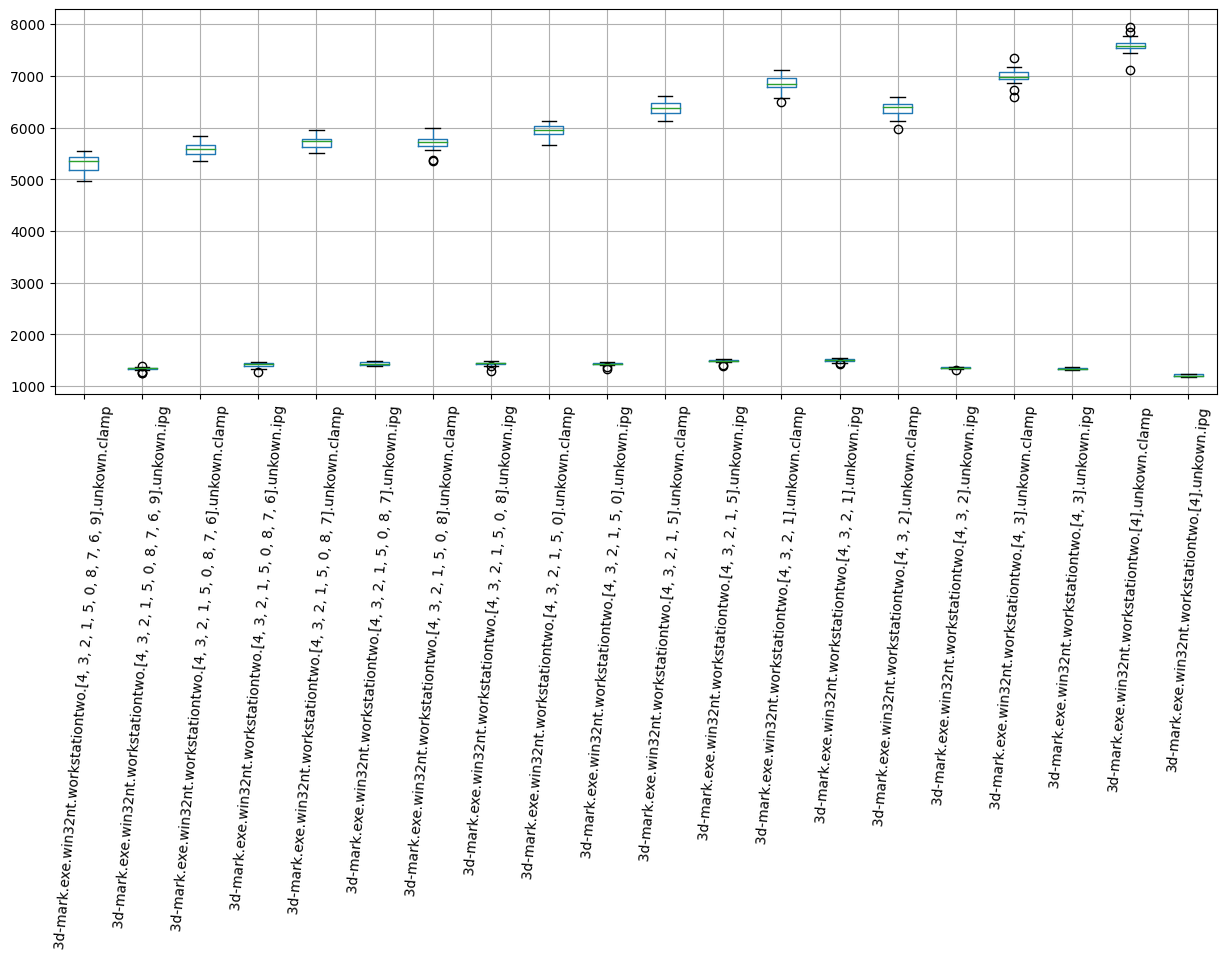

Dynamic CPU Energy Consumption in Watts


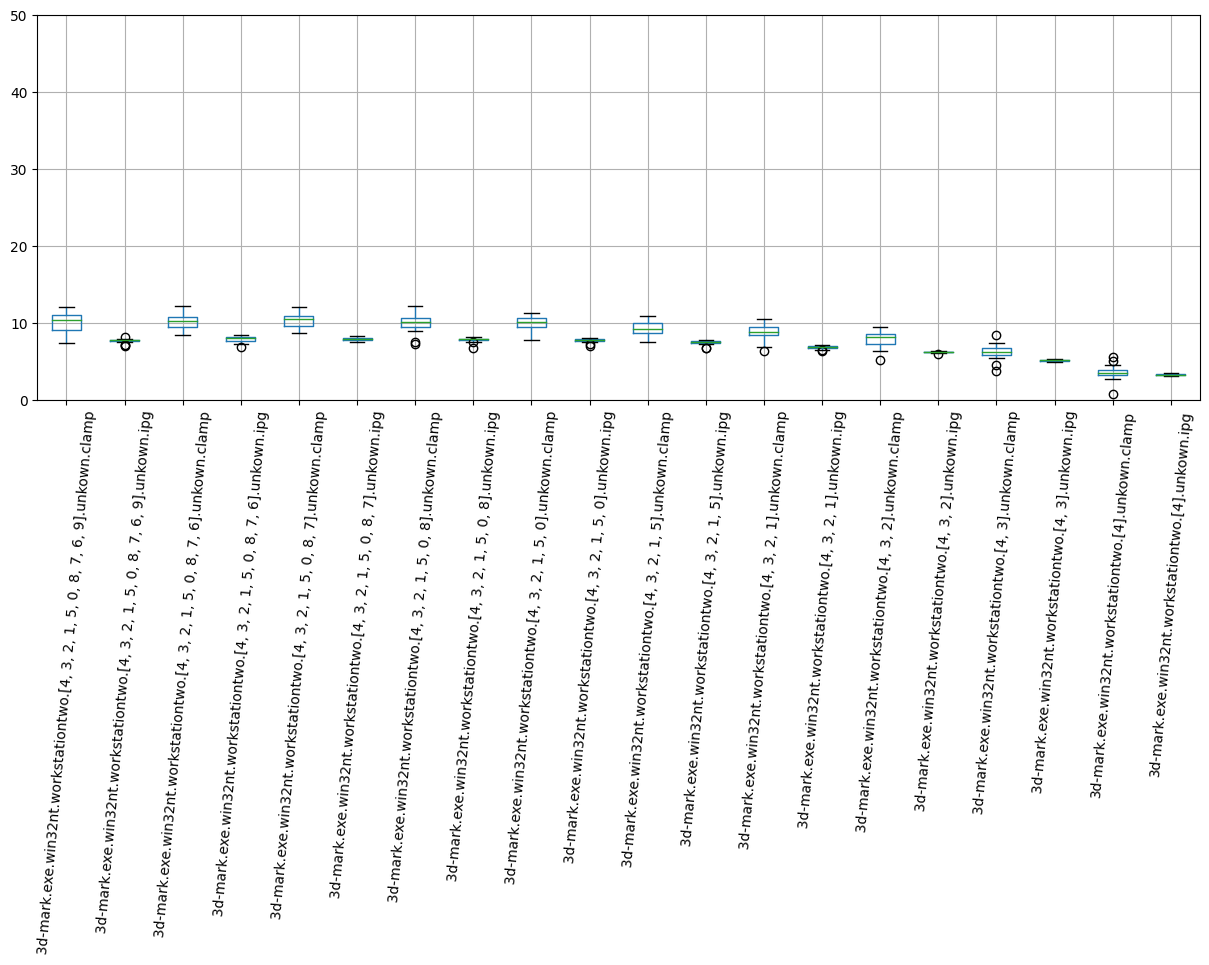

In [94]:
if get_measurements and show_plots:
    # print("Dynamic DRAM Energy Consumption in Watts")
    # dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_dram_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()

    print("Dynamic CPU Energy Consumption in Joiles")
    dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=85)
    dynamic_cpu_boxplot.plot()
    # plot.ylim(-100, 100)
    plot.show()
    
    print("Dynamic CPU Energy Consumption in Watts")
    dynamic_watt_cpu_boxplot = cpu_dynamic_watt_df.boxplot(figsize=(15,5), rot=85)
    dynamic_watt_cpu_boxplot.plot()
    plot.ylim(0,50)
    plot.show()
    
    

    # print("Dynamic GPU Energy Consumption in Watts")
    # dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_gpu_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()


In [95]:
def list_to_label(lst, mapper):
    if len(lst) == 1:
        return mapper[lst[0]]
    elif len(lst) == 2:
        return f"{mapper[lst[0]]} and {mapper[lst[1]]}"
    else:
        return ", ".join([mapper[x] for x in lst[:-1]]) + f" and {mapper[lst[-1]]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [96]:
dut_name_mapper = {
    "workstationone" : "DUT 1",
    "workstationtwo" : "DUT 2"
}

compiler_mapper = {
    "clang" : "Clang",
    "min-gw" : "MinGW",
    "intel-one-api" : "oneAPI",
    "msvc" : "MSVC"
}

test_case_mapper = {
    "fannkuch-redux.exe" : "FR",
    "mandelbrot.exe" : "MB",
    "nbody.exe" : "NB",
    "spectral-norm.exe" : "SN"
}

mi_mapper = {
    "ipg" : "IPG",
    "lhm" : "LHM",
    "clamp" : "Clamp",
    "plug" : "Plug",
    "scaphandre" : "SCAP",
    "scaphandre_isolated" : "SCAPI",
    "rapl" : "RAPL"
}

os_mapper = {
    "unix" : 'LIN',
    "win32nt" : "WIN"
}

In [97]:
box_plot_raw_data = [
    {
        "data" : cpu_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Average Energy Consumption (Joules)"
    },
    {
        "data" : cpu_dynamic_df,
        "name" : "CPU",
        "data_type" : "DEC",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 1000,
        "xlabel" : "Average DEC (Joules)"
    },
    {
        "data" : cpu_dynamic_watt_df,
        "name" : "CPU",
        "data_type" : "DEC per second",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Average DEC (Watts)"
    },
    # {
    #     "data" : dram_dynamic_df,
    #     "name" : "DRAM",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : dram_df,
    #     "name" : "DRAM",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 40,
    #     "xlabel" : "Total Energy Consumption (Joules)"
    # },
    # {
    #     "data" : gpu_dynamic_df,
    #     "name" : "GPU",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : gpu_df,
    #     "name" : "GPU",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 50,
    #     "xlabel" : "Total Energy Consumption (Watt)"
    # },
    {
        "data" : duration_df,
        "name" : "Runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

In [98]:
if generate_graphs and get_measurements:
    for plot_data in box_plot_raw_data:
        print("start")
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        plot.clf()
        # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
        
        if name == 'Runtime':
            title = f"The average duration"
        else:
            title = f"The {data_type} of the {name}"
        
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(
            data, 
            used_test_case_names, 
            used_mi_names, 
            used_dut_name, 
            used_allocated_cores, 
            used_compiler_str, 
            used_os_names,
            dut_name_mapper,
            compiler_mapper,
            test_case_mapper,
            mi_mapper,
            os_mapper
            )
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}".lower()
        
        c_test_cases = list_to_label(used_test_case_names, test_case_mapper)
        c_compiler = list_to_label(used_compilers, compiler_mapper)
        c_duts = list_to_label(used_dut_name, dut_name_mapper)
        c_measuring_instrument = list_to_label(used_mi_names, mi_mapper)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        # print(data)
        path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [99]:
# \addplot[mark=none, blue] coordinates {(1000,0) (1000,5)};

In [100]:
def remove_n_percent(df, column, percent):
    data_to_order = df[column]

    list(data_to_order).sort()
    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    percent = 20

    n = len(data_to_order)
    outliers = int(n*percent/100) #may want some rounding logic if n is small
    trimmed_data = data_to_order[outliers: n-outliers]
    
    return trimmed_data

def remove_n_first(df, column, n):
    data_to_order = df[column]

    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    trimmed_data = data_to_order[n:]
    
    return trimmed_data

In [101]:
# percent = 20
# n = len(used_df['spectral-norm.exe.win32nt.workstationtwo.[2].intel-one-api.ipg'])
# outliers = n*percent/100 #may want some rounding logic if n is small
# trimmed_data = sorted_data[outliers: n-outliers]

In [102]:
def  remove_outliers_z_score(df, column, limit):
    df['z_score'] = np.abs((df[column] - df[column].mean()) / df[column].std())

    # identify outliers as data points with z-score > 3
    outliers = df[column][df['z_score'] > limit]
    
    return [
        x for x in list(df[column]) if x not in list(outliers)
    ]

In [103]:
cochrans_data = {
    "" : ["with", "without", 'z', "percent", "count"]
}

if get_measurements:
    Z = 1.96
    E = 0.03

    # Z = 2.58
    # E = 0.01

    include_outliers = False

    used_df = cpu_dynamic_watt_df

    for column in used_df.columns:
        used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
        used_df_without_n_percent = remove_n_percent(used_df, column, 20)
        used_df_without_z_score_outliers = remove_outliers_z_score(used_df, column, 1.5)
        
        
        
        
        # used_df_remove_n = remove_n_first(used_df, column, 1000)
        # pd_removed = pd.DataFrame({column : used_df_remove_n})
        # used_df_remove_n = math_util.exclude_outliers(pd_removed, column)
        
        
        current_count = used_df[column].count()
        
        values = used_df_without_outlisers
        n_zero_without = math_util.get_cochran(values, Z, E)
        
        values = used_df_without_z_score_outliers
        n_zero_without_z_outliers = math_util.get_cochran(values, Z, E)
        
        # values = used_df_remove_n
        # n_zero_removed = math_util.get_cochran(values, Z, E)
        # print(n_zero_removed)
        
        values = used_df_without_n_percent
        n_zero_percent = math_util.get_cochran(values, Z, E)
        
        values = list(used_df[column])
        n_zero = math_util.get_cochran(values, Z, E)
        
        cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1), round(n_zero_without_z_outliers, 1), round(n_zero_percent, 1), current_count]

pd.DataFrame(cochrans_data).T

AssertionError: 20